In [1]:
# import packages
import numpy as np, pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt

from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy import stats

In [2]:
# read data
brancher = pd.read_csv("data/arbejdsmarkedsanalyse_brancher.csv", sep = ";",decimal=",",  encoding="latin-1")
koenAlder = pd.read_csv("data/arbejdsmarkedsanalyse_koen_alder.csv", sep = ";",decimal=",",  encoding="latin-1")
pd.set_option('display.max_colwidth', 250)


# Introduktion
- De to datasæt indeholder svar fra samme undersøgelse vedrørende sundhed på arbejdspladsen fra 2018
- arbejdsmarkedsanalyse_koen_alder er grupperet på køn og alder og arbejdsmarkedsanalyse_brancher er grupperet på brancher. 
- køn_alder indeholder 1308 rækker og 10 kolonner. Data er grupperet med fem aldersgrupper for begge køn og et gennemsnit af alle aldre
- brancher indeholder 8115 rækker og 41 kolonner. Der er 75 unikke brancher eks. "total" 
- Interessante kolonner fælles for det to datasæt:
    * Group:
        - køn_alder: Kvinder og mænd, samt begge fordelt på aldersgrupper
        - brancher: brancher, samt total for hvert spørgsmål og "uoplyst"
    * Topic label - overordnet spørgsmålskategori: 37 unikke
    * Question label - underkategori til Topic Label: 109 unikke
    * Akse - Udfaldsrum af svarmuligheder: fx "score (1-5 etc)", "andel i %" eller "antal timer" (branche indeholder også blanke felter her)
    * Ordforklaring - spørgsmål inkl. svarmuligheder
    * Antpers - antal personer der har svaret på spørgsmålet
    * Score (Indekseret score) - gennemsnitsscore for hvert spørgsmål i hver gruppe mellem 0 og 100 (for akse=score)
    * Score - gennemsnitsscore for hvert spørgsmål i hver gruppe
- Brancher indeholder derudover:
    * Type: kontinuert og diskontinuert
    * Akse indeholder blanke værdier (her er ingen score tilgængelig)
    * Score (Indekseret score) (gennemsnit) - gennemsnitsscore grupperet på hvert spørgsmål mellem 0 og 100 (for akse=score)
    * Score (Indekseret score) (gennemsnit) (label) - gennemsnitsscore grupperet på hvert spørgsmål
    * Score (Total) (Fixed) - fikset gennemsnitsscore pr. spørgsmål (negativ hvis "hoej score godt"=0)
    * Gennemsnit - samme som Score (Indekseret score) (gennemsnit) (label), ses kun i Total-rækker
    * Score (Total) - kun værdier i total-rækker, ellers samme som Score (Total) (Fixed)
    * Antpct - Antal % der har svaret ja kun vigtig for rækker med Akse "andel i %"
    * Hoej Score Godt - boolean: 0=nej, 1=ja 
     

# Køn og Alder

In [3]:
koenAlder.head(2)

,Group,Question Label,Topic Label,Year,Akse,Ordforklaring,Antpers,Farveskala,Gennemsnit,Score (Indekseret score) (gennemsnit) (label),Score (Indekseret score) (gennemsnit),Score (Indekseret score),Score
0,"Mænd, 55 - 64 år",Symptomer på angst,Angstsymptomer,2018,Score,"Spørgsmål: I de sidste fire uger, hvor meget har du været generet af; A) at du pludselig bliver bange uden grund; B) nervøsitet eller indre uro; C) anfald af rædsel eller panik; D) at bekymre dig for meget?\n\n-Slet ikke\n-Lidt / Noget / En hel d...",5080,38.852616,NaN,NaN,NaN,18.223967,0.911198
1,"Mænd, 45 - 54 år",Symptomer på angst,Angstsymptomer,2018,Score,"Spørgsmål: I de sidste fire uger, hvor meget har du været generet af; A) at du pludselig bliver bange uden grund; B) nervøsitet eller indre uro; C) anfald af rædsel eller panik; D) at bekymre dig for meget?\n\n-Slet ikke\n-Lidt / Noget / En hel d...",5367,29.425529,NaN,NaN,NaN,19.637802,0.981890


In [4]:
# drop redundant columns
koenAlder = koenAlder.drop(columns=['Score (Indekseret score) (gennemsnit)', 
                                    'Score (Indekseret score) (gennemsnit) (label)', 
                                    'Farveskala', 
                                    'Gennemsnit',
                                    'Year'])

In [5]:
koenAlder

,Group,Question Label,Topic Label,Akse,Ordforklaring,Antpers,Score (Indekseret score),Score
0,"Mænd, 55 - 64 år",Symptomer på angst,Angstsymptomer,Score,"Spørgsmål: I de sidste fire uger, hvor meget har du været generet af; A) at du pludselig bliver bange uden grund; B) nervøsitet eller indre uro; C) anfald af rædsel eller panik; D) at bekymre dig for meget?\n\n-Slet ikke\n-Lidt / Noget / En hel d...",5080,18.223967,0.911198
1,"Mænd, 45 - 54 år",Symptomer på angst,Angstsymptomer,Score,"Spørgsmål: I de sidste fire uger, hvor meget har du været generet af; A) at du pludselig bliver bange uden grund; B) nervøsitet eller indre uro; C) anfald af rædsel eller panik; D) at bekymre dig for meget?\n\n-Slet ikke\n-Lidt / Noget / En hel d...",5367,19.637802,0.981890
2,"Mænd, 35 - 44 år",Symptomer på angst,Angstsymptomer,Score,"Spørgsmål: I de sidste fire uger, hvor meget har du været generet af; A) at du pludselig bliver bange uden grund; B) nervøsitet eller indre uro; C) anfald af rædsel eller panik; D) at bekymre dig for meget?\n\n-Slet ikke\n-Lidt / Noget / En hel d...",3496,21.286060,1.064303
3,"Mænd, 25 - 34 år",Symptomer på angst,Angstsymptomer,Score,"Spørgsmål: I de sidste fire uger, hvor meget har du været generet af; A) at du pludselig bliver bange uden grund; B) nervøsitet eller indre uro; C) anfald af rædsel eller panik; D) at bekymre dig for meget?\n\n-Slet ikke\n-Lidt / Noget / En hel d...",1876,23.717605,1.185880
4,"Mænd, 18 - 24 år",Symptomer på angst,Angstsymptomer,Score,"Spørgsmål: I de sidste fire uger, hvor meget har du været generet af; A) at du pludselig bliver bange uden grund; B) nervøsitet eller indre uro; C) anfald af rædsel eller panik; D) at bekymre dig for meget?\n\n-Slet ikke\n-Lidt / Noget / En hel d...",591,22.635273,1.131764
...,...,...,...,...,...,...,...,...
1303,"Kvinder, 25 - 34 år",Fysisk vold,Vold og trusler,Andel (%),"Spørgsmål: Har du indenfor de sidste 12 måneder været udsat for fysisk vold på din arbejdsplads?\n\n-Nej, aldrig\n-Ja, sjældnere\n-Ja, månedligt\n-Ja, ugentligt\n-Ja, dagligt\n\nI resultaterne præsenteres andel (%), som har været udsat for fysisk...",2398,9.368184,9.368184
1304,"Kvinder, 18 - 24 år",Trusler,Vold og trusler,Andel (%),"Spørgsmål: Har du indenfor de sidste 12 måneder været udsat for trusler om vold på din arbejdsplads?\n\n-Nej, aldrig\n-Ja, sjældnere\n-Ja, månedligt\n-Ja, ugentligt\n-Ja, dagligt\n\nI resultaterne præsenteres andel (%), der har været udsat for tr...",691,7.562770,7.562770
1305,"Kvinder, 18 - 24 år",Fysisk vold,Vold og trusler,Andel (%),"Spørgsmål: Har du indenfor de sidste 12 måneder været udsat for fysisk vold på din arbejdsplads?\n\n-Nej, aldrig\n-Ja, sjældnere\n-Ja, månedligt\n-Ja, ugentligt\n-Ja, dagligt\n\nI resultaterne præsenteres andel (%), som har været udsat for fysisk...",690,7.334526,7.334526
1306,Kvinder,Trusler,Vold og trusler,Andel (%),"Spørgsmål: Har du indenfor de sidste 12 måneder været udsat for trusler om vold på din arbejdsplads?\n\n-Nej, aldrig\n-Ja, sjældnere\n-Ja, månedligt\n-Ja, ugentligt\n-Ja, dagligt\n\nI resultaterne præsenteres andel (%), der har været udsat for tr...",19694,10.985068,10.985068


In [6]:
# filte on akse type
ka_timer = koenAlder[koenAlder['Akse'] == 'Timer']
ka_score = koenAlder[koenAlder['Akse'] == 'Score']
ka_andel = koenAlder[koenAlder['Akse'] == 'Andel (%)']

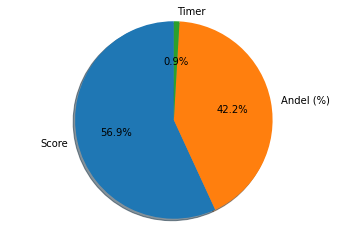

In [7]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels =  ['Score', 'Andel (%)', 'Timer']
sizes = [len(ka_score), len(ka_andel), len(ka_timer)]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

Tager udgangspunkt i de spørgsmål med akse=score, som hovedparten af data består af.
Der findes fem spørgsmål, der hver viser et gennemsnit af en række spørgsmål:
- Depressive symptomer
- Gennemsnit af spørgsmålene om ledelseskvalitet
- Vitalitet
- Mental sundhed
- Uoverskuelighed
Nedenstående figurer viser den gennemsnitlige score af ovenstående for mænd og kvinder.

In [8]:
ka_score.describe()

,Antpers,Score (Indekseret score),Score
count,744.000000,744.000000,744.000000
mean,6004.040323,63.824321,5.563264
std,5716.495583,15.745505,11.924162
min,485.000000,13.163605,0.911198
25%,2080.750000,57.564848,2.933049
50%,4468.000000,65.098405,3.322204
75%,5724.250000,75.712982,3.821697
max,20189.000000,88.695413,83.438474


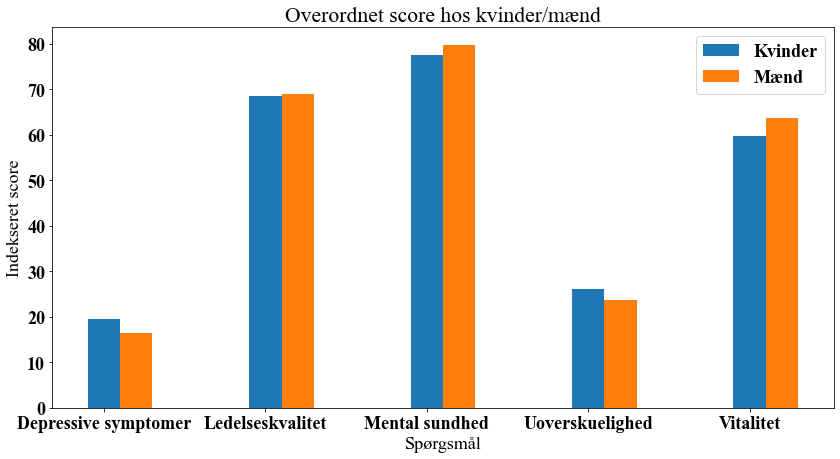

In [9]:
# udtræk overordnede svar
topics=['Spørgsmål: Samlet score', 'Spørgsmål: Den samlede score', 'Spørgsmål: En samlet score'] 

k_values = ka_score[(ka_score.Group=='Kvinder') 
                    & (ka_score.Ordforklaring.str.contains(topics[0]) 
                    | ka_score.Ordforklaring.str.contains(topics[1])
                    | ka_score.Ordforklaring.str.contains(topics[2])) ].sort_values(by=['Question Label'])["Score (Indekseret score)"].values
m_values = ka_score[(ka_score.Group=='Mænd') & (ka_score.Ordforklaring.str.contains(topics[0]) 
                    | ka_score.Ordforklaring.str.contains(topics[1])
                    | ka_score.Ordforklaring.str.contains(topics[2])) ].sort_values(by=['Question Label'])["Score (Indekseret score)"].values

font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 18}

plt.rc('font', **font)

plt.figure(num=None, figsize=(14, 7))

Labels=['Depressive symptomer', 'Ledelseskvalitet','Mental sundhed', 'Uoverskuelighed', 'Vitalitet']
y_pos=np.arange(len(Labels))
plt.bar(y_pos + 0, k_values,width=0.2, label='Kvinder')
plt.bar(y_pos + 0.2,m_values, width=0.2,label = 'Mænd')

plt.xticks(y_pos, Labels)

plt.legend(('Kvinder', 'Mænd'))
plt.ylabel('Indekseret score')
plt.xlabel('Spørgsmål')
plt.title("Overordnet score hos kvinder/mænd")
plt.show()


Ovenstående viser umiddelbart ikke den store forskel i mænd og kvinder, men for en sikkerheds skyld laves der en t-test:

In [10]:
stats.ttest_ind(m_values, k_values)

Ttest_indResult(statistic=0.01585179566217882, pvalue=0.9877408298606705)

Altså ikke nogen signifikant forskel.

## Arbejdstimer

In [11]:
ka_timer.describe()

,Antpers,Score (Indekseret score),Score
count,12.000000,12.000000,12.000000
mean,6257.833333,36.737113,36.737113
std,6185.572110,3.585739,3.585739
min,703.000000,28.434586,28.434586
25%,2408.000000,35.189981,35.189981
50%,4864.500000,36.289504,36.289504
75%,5988.500000,39.303142,39.303142
max,20170.000000,41.092896,41.092896


In [12]:
ka_timer[ka_timer.Group.str.contains('Kvinder')].sort_values(by=['Group'])["Group"]

129                Kvinder
126    Kvinder, 18 - 24 år
123    Kvinder, 25 - 34 år
120    Kvinder, 35 - 44 år
117    Kvinder, 45 - 54 år
114    Kvinder, 55 - 64 år
Name: Group, dtype: object

In [13]:
ka_timer_k = ka_timer[ka_timer.Group.str.contains('Kvinder')].sort_values(by=['Group'])["Score"].values
ka_timer_m = ka_timer[ka_timer.Group.str.contains('Mænd')].sort_values(by=['Group'])["Score"].values


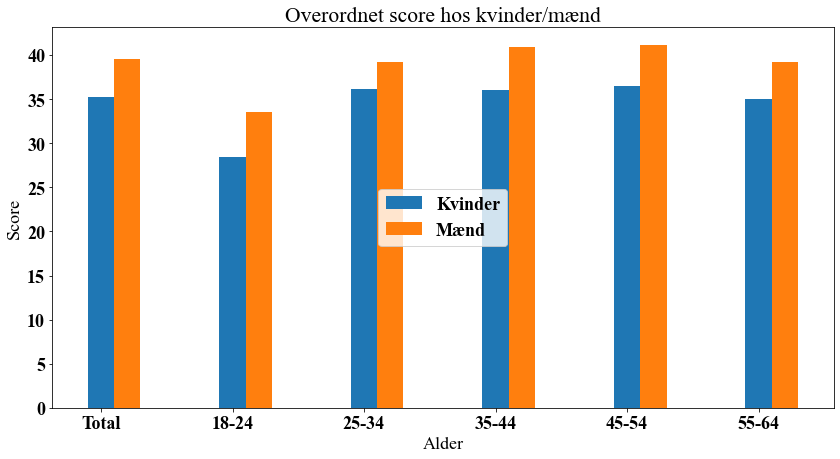

In [14]:
# udtræk overordnede svar
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 18}

plt.rc('font', **font)

plt.figure(num=None, figsize=(14, 7))

Labels=['Total', '18-24','25-34', '35-44', '45-54', '55-64']
y_pos=np.arange(len(Labels))
plt.bar(y_pos + 0, ka_timer_k,width=0.2, label='Kvinder')
plt.bar(y_pos + 0.2,ka_timer_m, width=0.2,label = 'Mænd')

plt.xticks(y_pos, Labels)

plt.legend(('Kvinder', 'Mænd'), loc='center')
plt.ylabel('Score')
plt.xlabel('Alder')
plt.title("Overordnet score hos kvinder/mænd")
plt.show()

Ud fra plottet giver det mening at teste om mænd arbejder signifikant mere end kvinder.

In [15]:
stats.ttest_ind(ka_timer_k[1:], ka_timer_m[1:], alternative='less')

Ttest_indResult(statistic=-2.1557757722164, pvalue=0.03160200694161664)

Altså kan vi ikke afvise, at kvinder arbejder færre timer end mænd baseret på disse data.

# Brancher

In [16]:
brancher_filter = brancher.filter(items=['Group',
                                         'Akse',
                             'Topic Label',                                          
                             'Question Label', 
                             'Antpct', 
                             'Antpers',
                             'Hoej Score Godt',
                             'Score (Indekseret score) (gennemsnit)',
                             'Score (Indekseret score) (gennemsnit) (label)', 
                             'Score (Total) (Fixed)', 
                             'Gennemsnit', 
                             'Score (Indekseret score)',
                             'Score (Total)', 
                             'Score',
                              'Sluttekst'])


brancher_filter = brancher_filter[brancher_filter.Akse.notna()]
brancher_filter.head(2)

,Group,Akse,Topic Label,Question Label,Antpct,Antpers,Hoej Score Godt,Score (Indekseret score) (gennemsnit),Score (Indekseret score) (gennemsnit) (label),Score (Total) (Fixed),Gennemsnit,Score (Indekseret score),Score (Total),Score,Sluttekst
0,Bibliotekarer og beskæftigede med kultur,Score,Kvantitative krav og grænseløshed,Ikke nok tid til arbejdsopgaver,NaN,224,0,52.180881,2.609044,-2.609044,NaN,53.173963,NaN,2.658698,I resultaterne præsenteres den gennemsnitlige score (1-5).
1,Bogholdere,Score,Kvantitative krav og grænseløshed,Ikke nok tid til arbejdsopgaver,NaN,388,0,52.180881,2.609044,-2.609044,NaN,51.324841,NaN,2.566242,I resultaterne præsenteres den gennemsnitlige score (1-5).


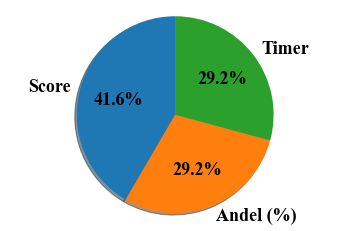

In [17]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels =  ['Score', 'Andel (%)', 'Timer']
sizes = [len(brancher[brancher.Akse=='Score']), len(brancher[brancher.Akse=='Andel (%)']), len(brancher[brancher.Akse=='Andel (%)'])]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

Starter med at fjerne Total rækkerne, og eksludere de fem overordnede emner

In [18]:
ex_total = brancher_filter[(brancher_filter.Akse=='Score') & ~(brancher_filter.Group=='Total') & ~(brancher_filter.Group=='Uoplyst')]
ex_total = ex_total[~ex_total.Sluttekst.str.contains("Scoren er beregnet som")]
ex_total_hoej = ex_total[ex_total["Hoej Score Godt"] == 1]
ex_total_lav = ex_total[ex_total["Hoej Score Godt"] == 0]
print(len(ex_total))
print(len(ex_total_hoej))
print(len(ex_total_lav))

ex_total.head()


4218
2812
1406


,Group,Akse,Topic Label,Question Label,Antpct,Antpers,Hoej Score Godt,Score (Indekseret score) (gennemsnit),Score (Indekseret score) (gennemsnit) (label),Score (Total) (Fixed),Gennemsnit,Score (Indekseret score),Score (Total),Score,Sluttekst
0,Bibliotekarer og beskæftigede med kultur,Score,Kvantitative krav og grænseløshed,Ikke nok tid til arbejdsopgaver,NaN,224,0,52.180881,2.609044,-2.609044,NaN,53.173963,NaN,2.658698,I resultaterne præsenteres den gennemsnitlige score (1-5).
1,Bogholdere,Score,Kvantitative krav og grænseløshed,Ikke nok tid til arbejdsopgaver,NaN,388,0,52.180881,2.609044,-2.609044,NaN,51.324841,NaN,2.566242,I resultaterne præsenteres den gennemsnitlige score (1-5).
2,"Brandmænd, reddere og sikkerhedsvagter",Score,Kvantitative krav og grænseløshed,Ikke nok tid til arbejdsopgaver,NaN,189,0,52.180881,2.609044,-2.609044,NaN,45.297700,NaN,2.264885,I resultaterne præsenteres den gennemsnitlige score (1-5).
3,Bude og kurerer,Score,Kvantitative krav og grænseløshed,Ikke nok tid til arbejdsopgaver,NaN,182,0,52.180881,2.609044,-2.609044,NaN,54.245458,NaN,2.712273,I resultaterne præsenteres den gennemsnitlige score (1-5).
4,"Bus- og taxachauffører, lokoførere m.fl.",Score,Kvantitative krav og grænseløshed,Ikke nok tid til arbejdsopgaver,NaN,280,0,52.180881,2.609044,-2.609044,NaN,46.182196,NaN,2.309110,I resultaterne præsenteres den gennemsnitlige score (1-5).


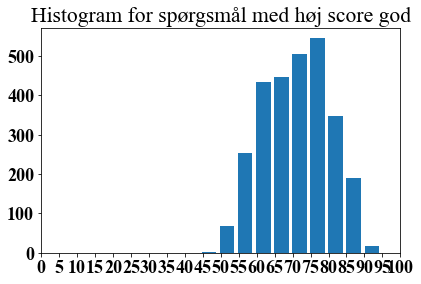

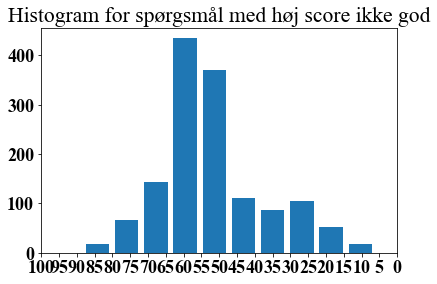

In [19]:
plt.figure()
plt.hist(ex_total_hoej['Score (Indekseret score)'],bins = 10, rwidth=0.8)
plt.locator_params(axis='x', nbins=20)
plt.tight_layout()
plt.title('Histogram for spørgsmål med høj score god')
plt.xlim(0,100)
plt.show()

plt.figure()
plt.hist(ex_total_lav['Score (Indekseret score)'],bins = 10, rwidth=0.8)
plt.locator_params(axis='x', nbins=20)
plt.tight_layout()
plt.title('Histogram for spørgsmål med høj score ikke god')
plt.xlim(100,0)
plt.show()


Fra histogrammerne ovenfor tyder det på en højere varians i de svar hvor den lave score er god. Samt er det værd at notere, at middelværdien ligger væsentligt "højere" i de spørgsmål med høj score god. 

In [20]:
ex_total_hoej.describe()

,Antpct,Antpers,Hoej Score Godt,Score (Indekseret score) (gennemsnit),Score (Indekseret score) (gennemsnit) (label),Score (Total) (Fixed),Gennemsnit,Score (Indekseret score),Score (Total),Score
count,0.0,2812.000000,2812.0,2812.000000,2812.000000,2812.000000,0.0,2812.000000,0.0,2812.000000
mean,NaN,441.594950,1.0,71.602822,3.689869,3.689869,NaN,70.961838,NaN,3.657422
std,NaN,424.156839,0.0,8.497075,0.869235,0.869235,NaN,9.137480,NaN,0.886379
min,NaN,21.000000,1.0,54.645973,2.732299,2.732299,NaN,44.203196,NaN,2.210160
25%,NaN,187.750000,1.0,64.615988,3.230799,3.230799,NaN,63.833765,NaN,3.191688
50%,NaN,271.000000,1.0,73.679110,3.683956,3.683956,NaN,71.826303,NaN,3.591315
75%,NaN,566.000000,1.0,77.477460,3.873873,3.873873,NaN,77.590894,NaN,3.879818
max,NaN,2089.000000,1.0,86.076313,8.339333,8.339333,NaN,94.554286,NaN,8.926919


In [21]:
ex_total_lav.describe()

,Antpct,Antpers,Hoej Score Godt,Score (Indekseret score) (gennemsnit),Score (Indekseret score) (gennemsnit) (label),Score (Total) (Fixed),Gennemsnit,Score (Indekseret score),Score (Total),Score
count,0.0,1406.000000,1406.0,1406.000000,1406.000000,1406.000000,0.0,1406.000000,0.0,1406.000000
mean,NaN,452.231152,0.0,51.882352,2.681340,-2.681340,NaN,51.931128,NaN,2.689625
std,NaN,433.604569,0.0,13.624853,0.661496,0.661496,NaN,14.730705,NaN,0.826116
min,NaN,35.000000,0.0,23.925724,1.196286,-3.848065,NaN,6.266978,NaN,0.626698
25%,NaN,191.000000,0.0,40.781674,2.559969,-3.085254,NaN,46.408381,NaN,2.368227
50%,NaN,271.000000,0.0,56.125955,2.869084,-2.869084,NaN,54.613293,NaN,2.768151
75%,NaN,575.750000,0.0,61.545874,3.085254,-2.559969,NaN,61.204805,NaN,3.098126
max,NaN,2109.000000,0.0,76.961292,3.848065,-1.196286,NaN,88.333436,NaN,6.666446


## Høj score god

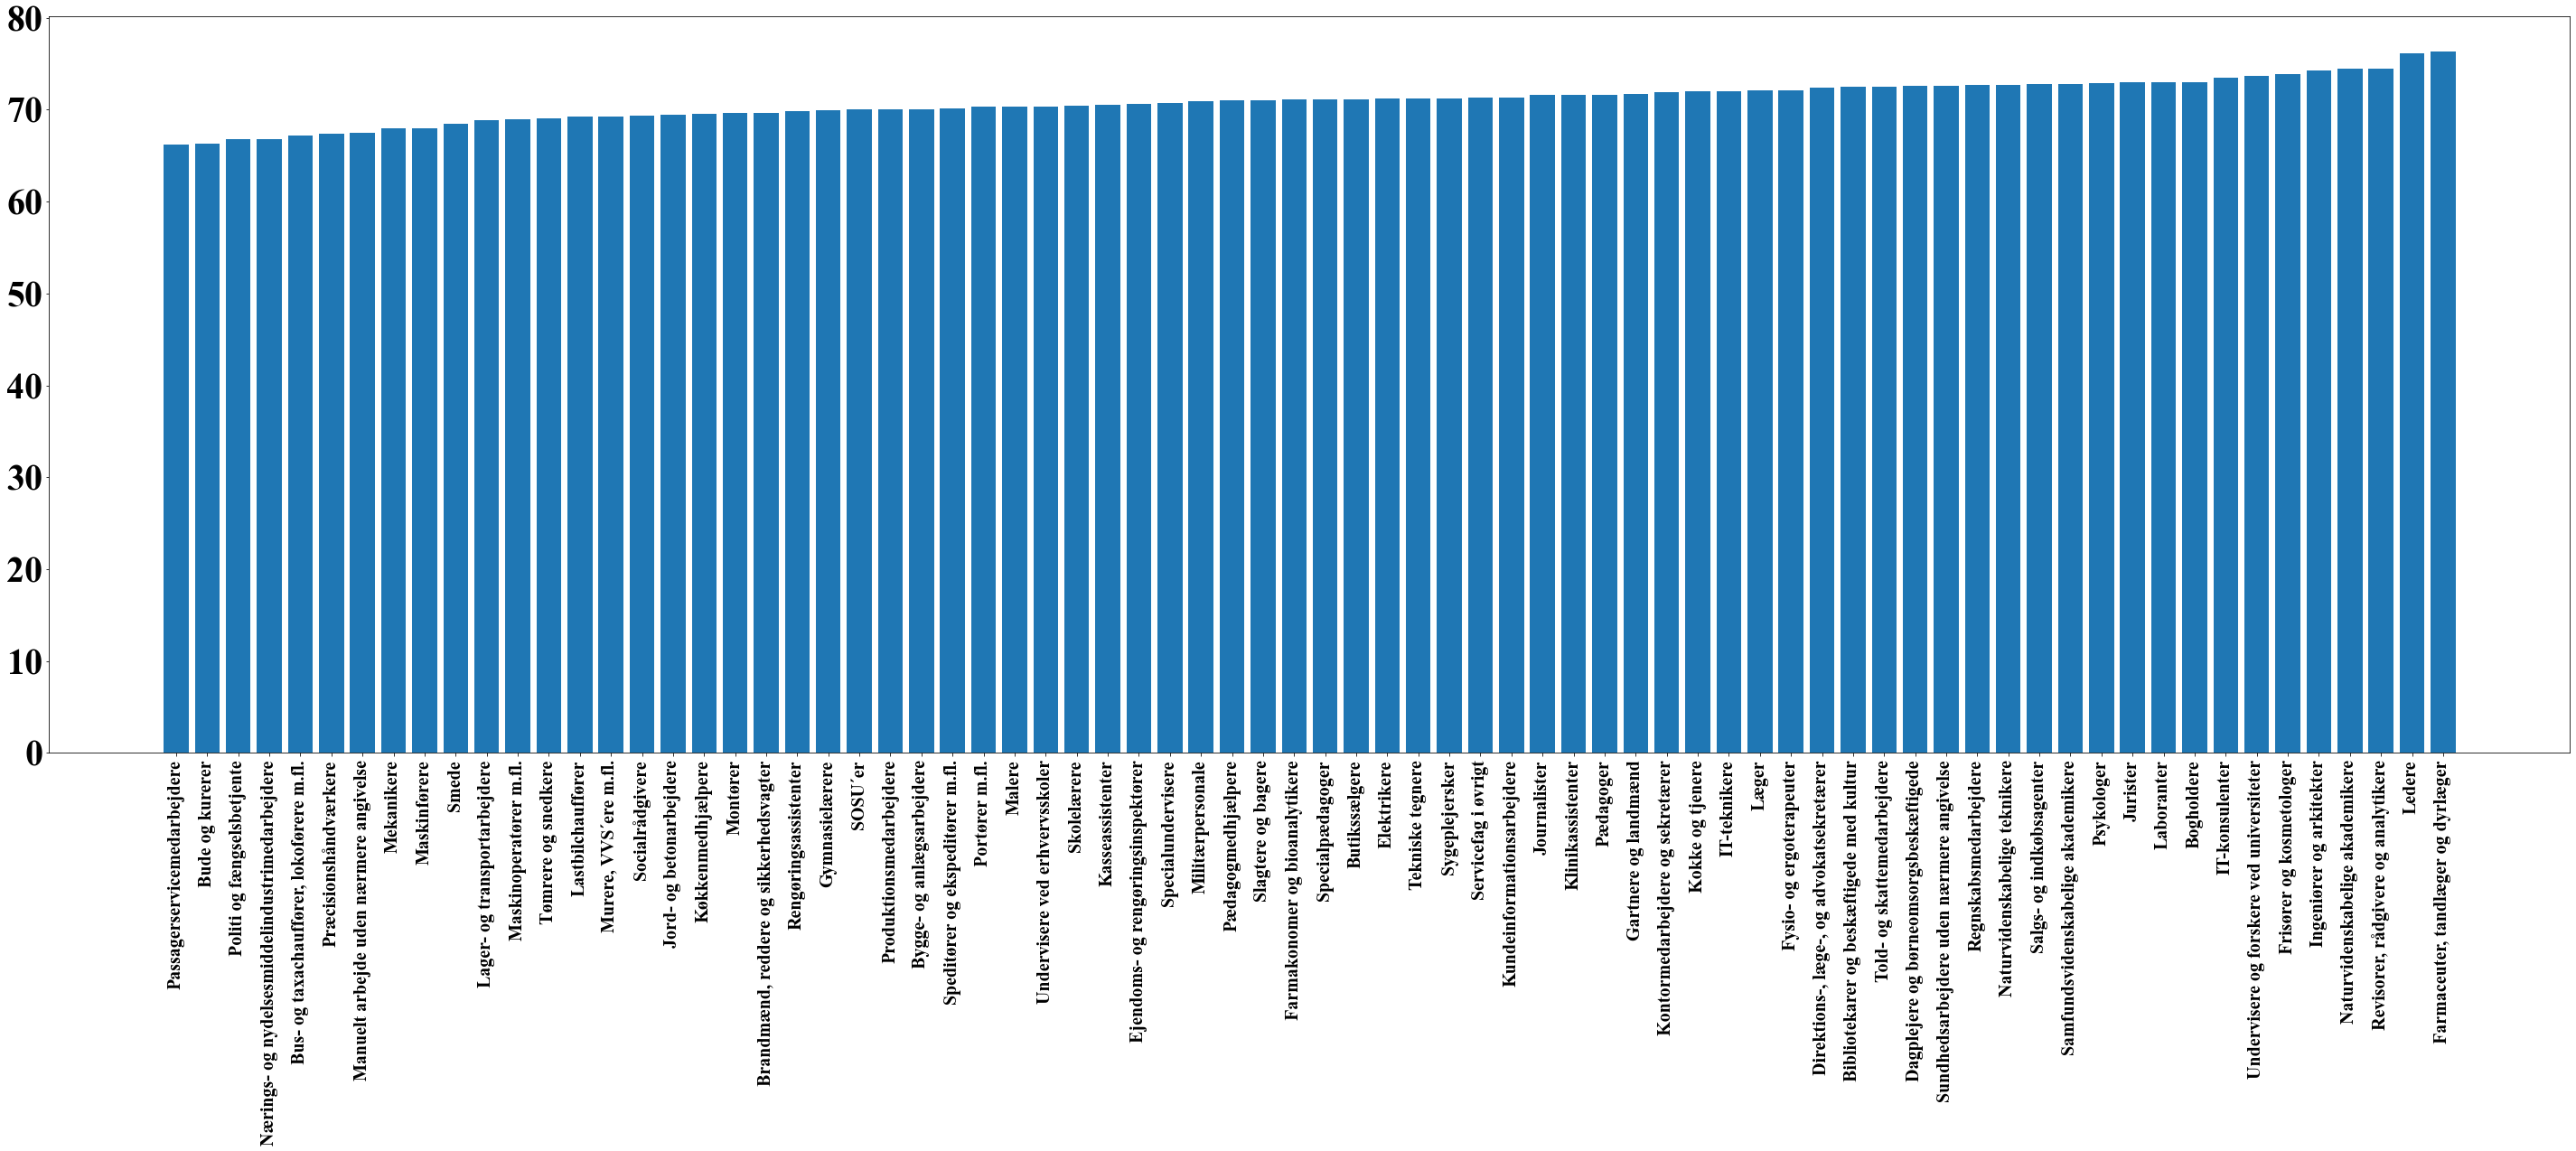

In [22]:
brancher_grouped_sorted = ex_total_hoej.groupby(['Group']).mean().sort_values(by=['Score (Indekseret score)'])
x = brancher_grouped_sorted.index

plt.figure(figsize=(50,15))
# Create bars and choose color
x = brancher_grouped_sorted.index
y = brancher_grouped_sorted['Score (Indekseret score)']
plt.bar(brancher_grouped_sorted.index, brancher_grouped_sorted['Score (Indekseret score)'])
 
plt.xticks(brancher_grouped_sorted.index, rotation='vertical', size=20) 

# plt.ylim(np.min(y)-5,np.max(y)+5)
plt.yticks(size=40)  
# # Create names

 
# Show gra
plt.show()




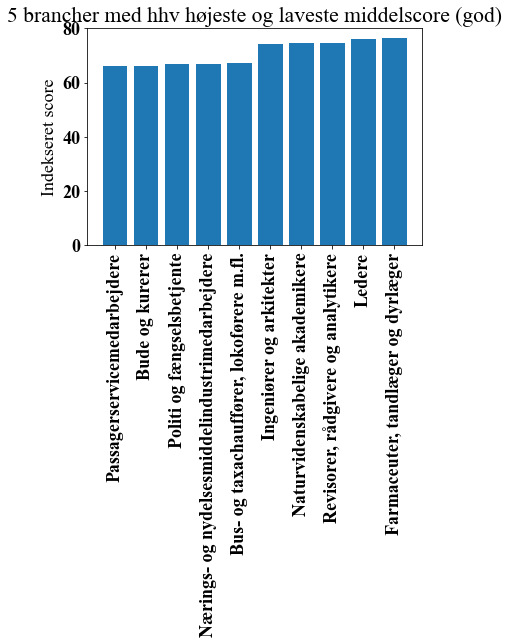

In [23]:
x1 = list(brancher_grouped_sorted.index[:5]) + list(brancher_grouped_sorted.index[-5:])
y1 = np.concatenate([brancher_grouped_sorted['Score (Indekseret score)'][:5].values, brancher_grouped_sorted['Score (Indekseret score)'][-5:].values])

plt.figure()
plt.bar(x1, y1)
# Add title and axis names
plt.title('5 brancher med hhv højeste og laveste middelscore (god)')
plt.ylabel('Indekseret score')
plt.xticks(x1, rotation='vertical')
plt.show()

Ud fra bar plottet ses en tendens til, jobs hvor der kræves fysisk hårdt arbejde ligger i scorer gennemsnitligt lavt, mens dem med høj uddanelse scorer gennemsnitligt højt. T-test om de fem højeste og laveste er forskellige:

In [24]:
stats.ttest_ind(y[:5], y[-5:])

Ttest_indResult(statistic=-17.52287606082815, pvalue=1.1485582924132472e-07)

## Høj score ikke god

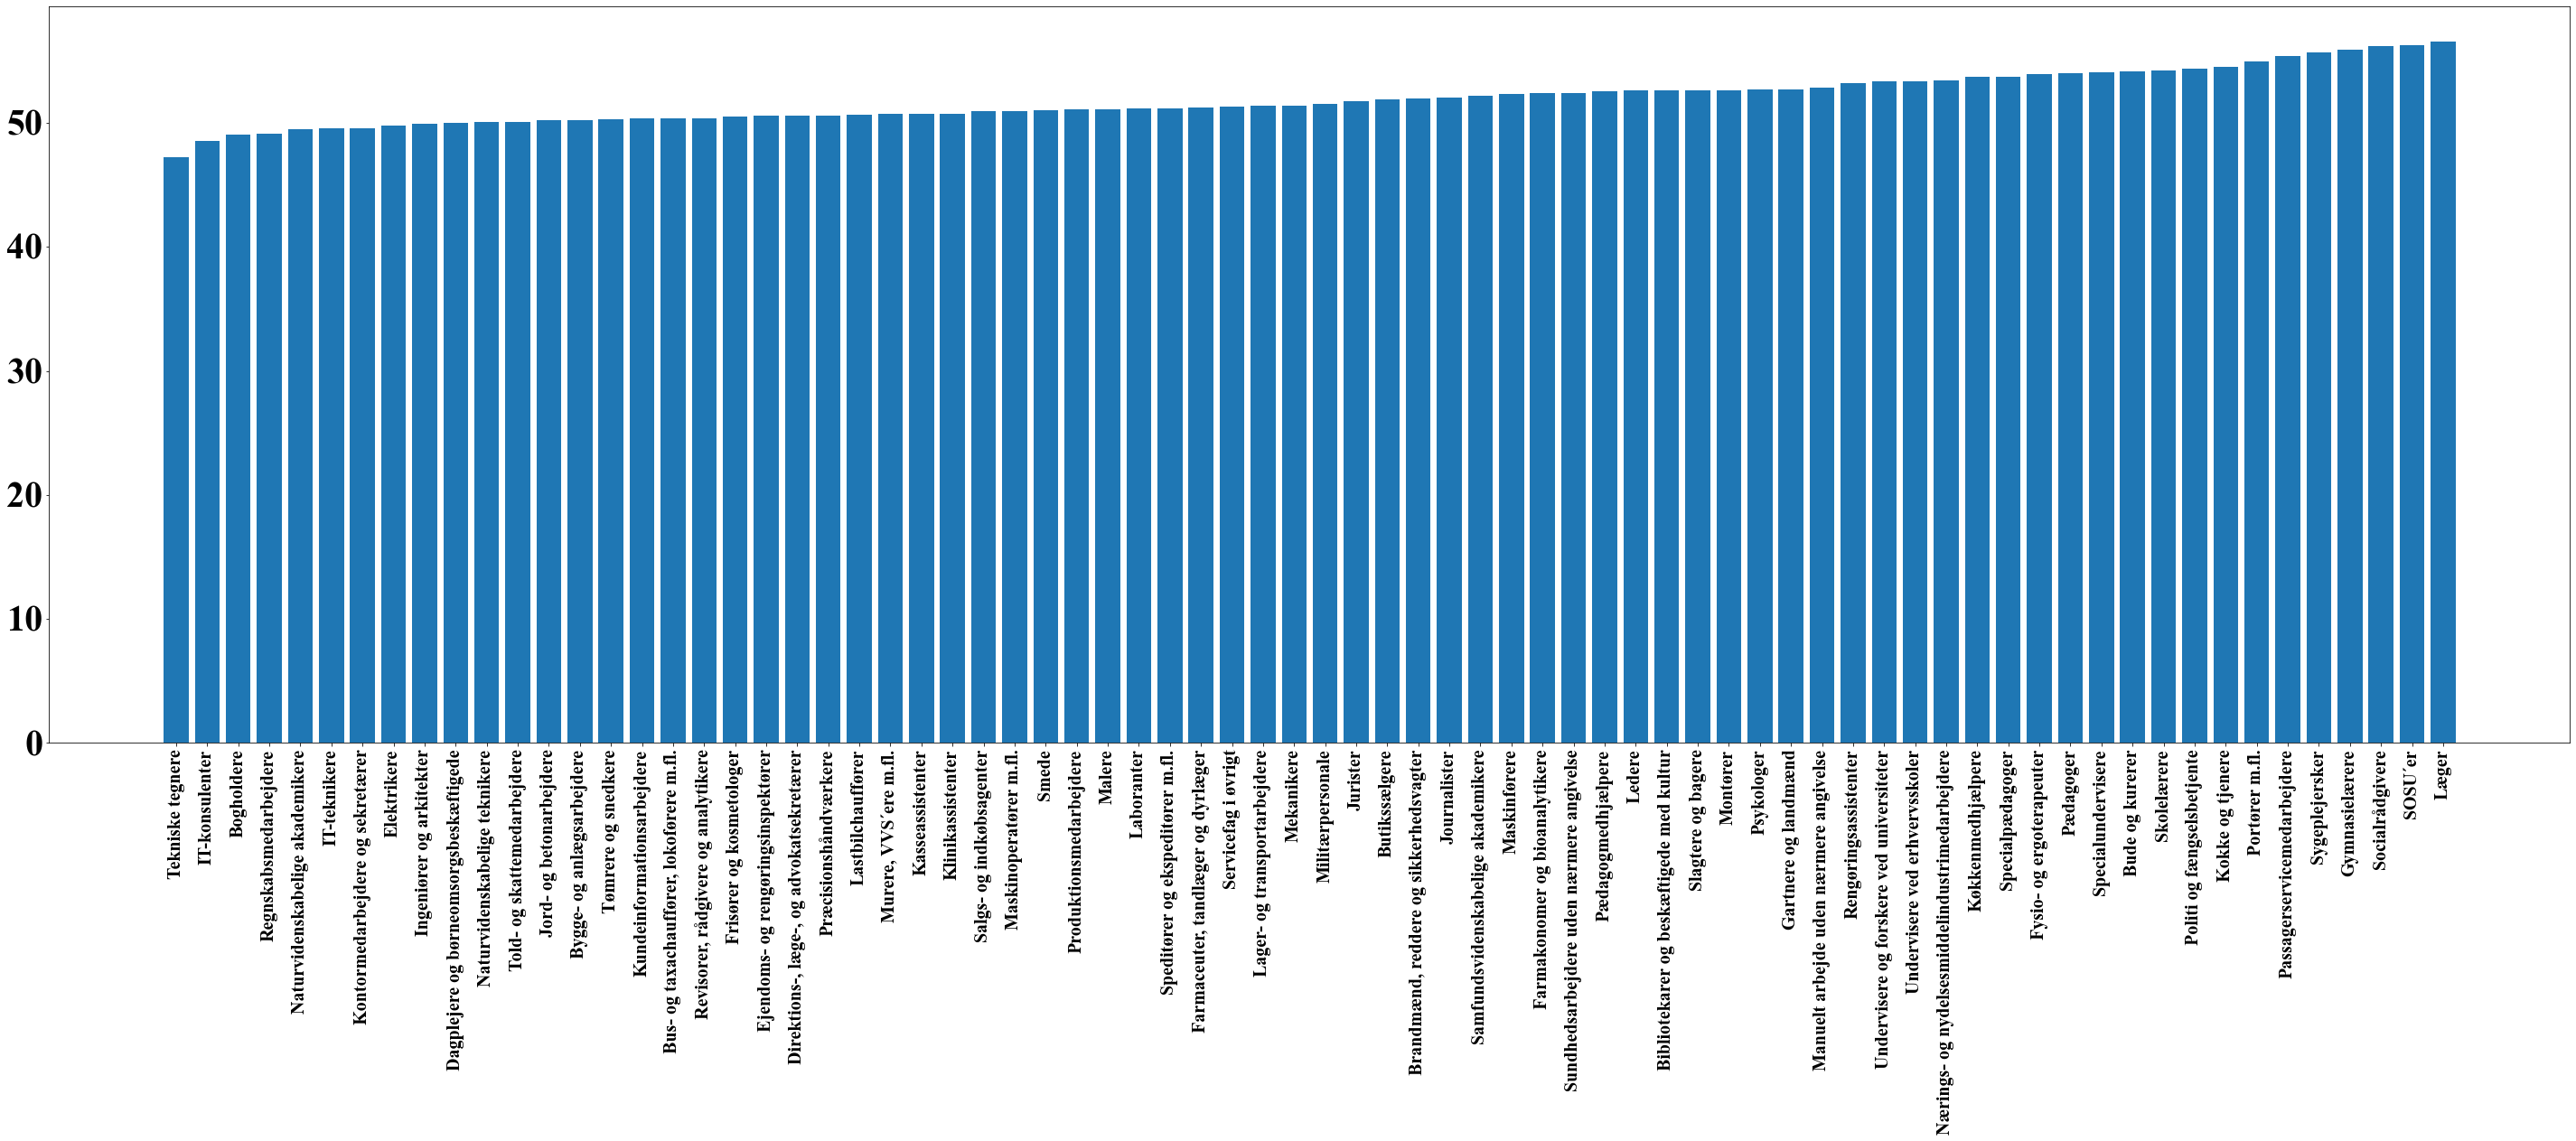

In [25]:
brancher_grouped_sorted2 = ex_total_lav.groupby(['Group']).mean().sort_values(by=['Score (Indekseret score)'])
x2 = brancher_grouped_sorted2.index

plt.figure(figsize=(50,15))
# Create bars and choose color
x2 = brancher_grouped_sorted2.index
y2 = brancher_grouped_sorted2['Score (Indekseret score)']
plt.bar(brancher_grouped_sorted2.index, brancher_grouped_sorted2['Score (Indekseret score)'])
plt.xticks(brancher_grouped_sorted2.index, rotation='vertical', size=20) 

# plt.ylim(np.min(y)-5,np.max(y)+5)
plt.yticks(size=40)  
# # Create names
 
# Show gra
plt.show()


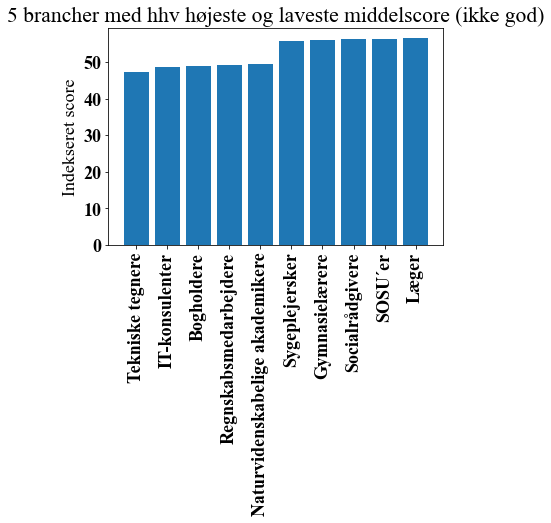

In [26]:
x3 = list(brancher_grouped_sorted2.index[:5]) + list(brancher_grouped_sorted2.index[-5:])
y3 = np.concatenate([brancher_grouped_sorted2['Score (Indekseret score)'][:5].values, brancher_grouped_sorted2['Score (Indekseret score)'][-5:].values])

plt.figure()
plt.bar(x3, y3)
# Add title and axis names
plt.title('5 brancher med hhv højeste og laveste middelscore (ikke god)')
plt.ylabel('Indekseret score')
plt.xticks(x3, rotation='vertical')
plt.show()

Her ses nogle lidt andre resultater, grupper der arbejder med mennesker ligger i bunden.
T-test om de fem højeste og fem laveste er signifikant forskellige:

In [27]:
stats.ttest_ind(y3[:5], y3[-5:])

Ttest_indResult(statistic=-17.403242420898206, pvalue=1.2117330690962664e-07)